WRC+ Predections

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/major_leauge_preds')

import predections

In [174]:
fg = pd.read_csv('./data/full/fg_00_24.csv')
nn_02_preds = pd.read_csv('./predicted_data/wrc_pred/nn_02_23_preds.csv')
nn_15_preds = pd.read_csv('./predicted_data/wrc_pred/nn_15_23_preds.csv')
nn_23_preds = pd.read_csv('./predicted_data/wrc_pred/nn_23_preds.csv')
reg_02_preds = pd.read_csv('./predicted_data/wrc_pred/reg_02_23_preds.csv')
reg_15_preds = pd.read_csv('./predicted_data/wrc_pred/reg_15_23_preds.csv')
reg_23_preds = pd.read_csv('./predicted_data/wrc_pred/reg_23_preds.csv')
zips_25 = pd.read_csv('./data/cleaned/zips_25.csv')

age_curve = pd.read_csv('./predicted_data/age_curves.csv')

basic cleaning

In [175]:
reg_02_preds = reg_02_preds.rename(columns={'Name': 't1'})
reg_15_preds = reg_15_preds.rename(columns={'Name': 't1'})
reg_23_preds = reg_23_preds.rename(columns={'Name': 't1'})

In [176]:
reg_02_preds = reg_02_preds.rename(columns={'0': 'proj_wrc+'})
reg_15_preds = reg_15_preds.rename(columns={'0': 'proj_wrc+'})
reg_23_preds = reg_23_preds.rename(columns={'0': 'proj_wrc+'})

In [177]:
nn_02_preds = nn_02_preds.drop(columns=['Unnamed: 0'])
nn_15_preds = nn_15_preds.drop(columns=['Unnamed: 0'])
nn_23_preds = nn_23_preds.drop(columns=['Unnamed: 0'])
reg_02_preds = reg_02_preds.drop(columns=['Unnamed: 0'])
reg_15_preds = reg_15_preds.drop(columns=['Unnamed: 0'])
reg_23_preds = reg_23_preds.drop(columns=['Unnamed: 0'])

uniform names

In [178]:
def clean_names(df):
    df['t1'] = df['t1'].str.split(',').str[0]
    return df

In [179]:
# apply function
nn_02_preds = clean_names(nn_02_preds)
nn_15_preds = clean_names(nn_15_preds)
nn_23_preds = clean_names(nn_23_preds)

#### AVG of Projections

merge dfs together

In [180]:
# merge all dfs together
merged_preds = nn_02_preds.rename(columns={'proj_wrc+': 'proj_wrc+_N02'})

merged_preds = merged_preds.merge(
    nn_15_preds,
    on='t1',
    how='outer',
    suffixes=('', "_N15")
)

merged_preds = merged_preds.merge(
    nn_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_N23')
)

merged_preds = merged_preds.merge(
    reg_02_preds,
    on='t1',
    how='outer',
    suffixes=("", "_R02")
)

merged_preds = merged_preds.merge(
    reg_15_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R15')
)

merged_preds = merged_preds.merge(
    reg_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R23')
)

# rename to name col
merged_preds = merged_preds.rename(columns={'t1':'Name', 'proj_wrc+': 'proj_wrc+_N15'})


In [181]:
import unicodedata
def remove_accents(name):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    )

Add Zip

In [182]:
# fix name to fit other format
zips_25['Name'] =  zips_25['Name'].str.lower()
zips_25['Name'] = zips_25['Name'].apply(remove_accents)
zips_25['Name'] = zips_25['Name'].str.replace(r'[^a-z\s]', '', regex=True)
zips_wrc = zips_25[['Name', 'wRC+']]

In [183]:
merged_preds = merged_preds.merge(zips_wrc, 
                                on='Name',  
                                how='outer',
                                suffixes=('', '_zip'))

In [184]:
merged_preds = merged_preds.rename(columns={'wRC+':'ZIPS'})

Add Age

In [185]:
fg = fg.query('Season == 2024')
fg['Name'] =  fg['Name'].str.lower()
fg['Name'] = fg['Name'].apply(remove_accents)
fg['Name'] = fg['Name'].str.replace(r'[^a-z\s]', '', regex=True)
fg_age = fg[['Name', 'Age']]
fg_age = fg_age.reset_index()
fg_age = fg_age.drop(columns=['index'])

In [186]:
# Merge with fg_age to add Age column
merged_preds = merged_preds.merge(fg_age, 
                                on='Name',  
                                how='outer')
                             

Age Curves Cleaning

In [187]:
age_curve = age_curve.drop(columns=['Unnamed: 0'])
age_curve.loc[0, 'wRC+ % change'] = 1.975003287933701
age_curve.loc[1, 'wRC+ % change'] = 1.75003287933701

#### Projection

model weighting

In [188]:
# Define weights for each column
weights = {
    'proj_wrc+_N23': 0.075,
    'proj_wrc+_N15': 0.075,
    'proj_wrc+_N02': 0.05,
    'proj_wrc+_R23': 0.2,
    'proj_wrc+_R15': 0.3,
    'proj_wrc+_R02': 0.3
}

def weighted_row_average(row, weights):
    vals = []
    wts = []
    for col, wt in weights.items():
        val = row[col]
        if not pd.isna(val):
            vals.append(val * wt)
            wts.append(wt)
    if wts:
        return sum(vals) / sum(wts)
    else:
        return np.nan

merged_preds['DIPS'] = merged_preds.apply(lambda row: weighted_row_average(row, weights), axis=1)

In [189]:
merged_preds = merged_preds[merged_preds['DIPS'].notna()]

Age Adjustment

In [190]:
# Create a dictionary from age_curve for faster lookup
age_adjustments = dict(zip(age_curve['Age'], age_curve['wRC+ % change']))

# Apply age adjustments to DIPS projections
for idx in merged_preds.index:
    player_age = merged_preds.loc[idx, 'Age'] + 1
    if player_age in age_adjustments:
        # Add 1 to the percentage change to get the multiplier
        age_multiplier = 1 + (age_adjustments[player_age] / 100)
        merged_preds.loc[idx, 'DIPS'] = merged_preds.loc[idx, 'DIPS'] * age_multiplier

WRC+ Distribution Adjustement
<br>
<small> Ensurring the distrubtion of data is consitent with historical disturbutions of data (work in stat distrubtion folder)
<br>
std        25.876430
25%        83.112436
50%        99.416733
75%       116.713857

In [191]:
# target median, q1 and q3 based on historical data
target_median = 100
target_q1 = 82.0
target_q3 = 115
target_iqr = target_q3 - target_q1

data_column = merged_preds['DIPS']

# find og values
original_q1 = data_column.quantile(0.25)
original_median = data_column.median()
original_q3 = data_column.quantile(0.75)
original_iqr = original_q3 - original_q1

# transform to desired shape
if original_iqr != 0 and not pd.isna(original_iqr):
    merged_preds['DIPS'] = (data_column - original_median) * (target_iqr / original_iqr) + target_median
else:
    merged_preds['DIPS'] = np.nan #


Regress Outlier Values to Mean

In [192]:
regression_strength = 0.2

# IQR Bounds
q1 = merged_preds[ 'DIPS'].quantile(0.25)
q3 = merged_preds[ 'DIPS'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 2 * iqr
upper_bound = q1 + 2 * iqr

# Calculate the mean of the transformed column
mean_val = merged_preds[ 'DIPS'].mean()

# Identify outliers
outliers_mask = (merged_preds[ 'DIPS'] < lower_bound) | (merged_preds[ 'DIPS'] > upper_bound)

# apply regression
if outliers_mask.any():
    original_outlier_values = merged_preds.loc[outliers_mask, 'DIPS']
    regressed_values = original_outlier_values * (1 - regression_strength) + mean_val * regression_strength
    merged_preds.loc[outliers_mask, 'DIPS'] = regressed_values

analysis

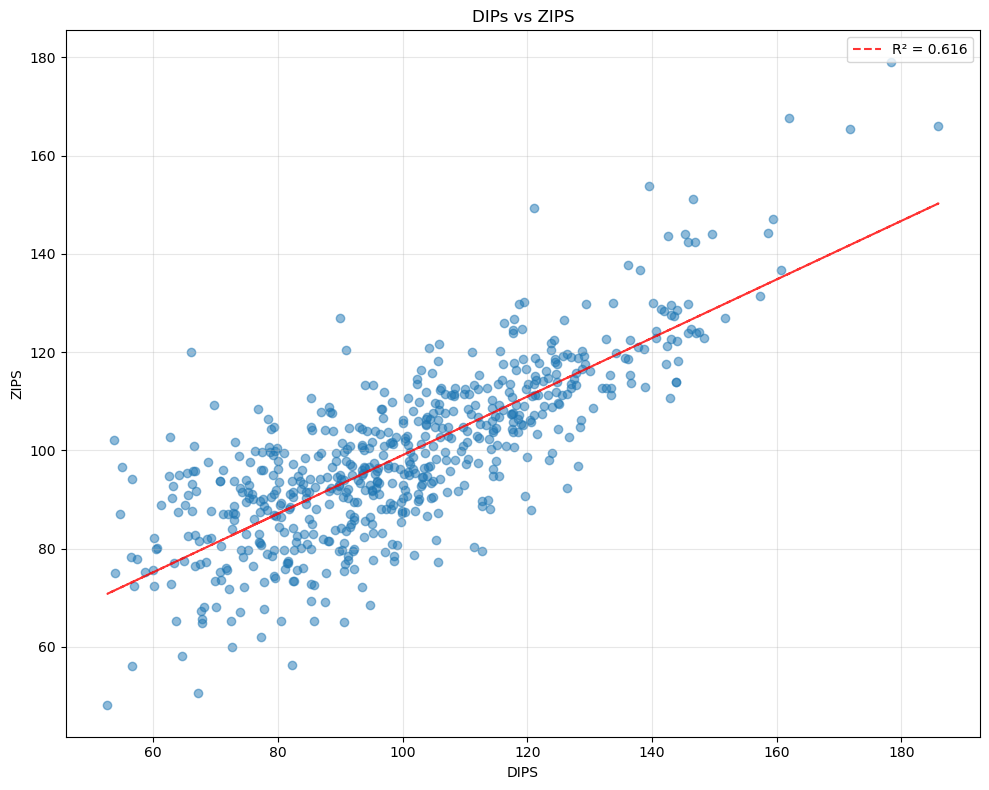

In [152]:
merged_preds['proj_diff'] = abs(merged_preds['DIPS'] - merged_preds['ZIPS'])
plt.figure(figsize=(10, 8))
plt.scatter(merged_preds['DIPS'], merged_preds['ZIPS'], alpha=0.5)

# Add line of best fit
z = np.polyfit(merged_preds['DIPS'], merged_preds['ZIPS'], 1)
p = np.poly1d(z)
r2 = np.corrcoef(merged_preds['DIPS'], merged_preds['ZIPS'])[0,1]**2

plt.plot(merged_preds['DIPS'], p(merged_preds['DIPS']), "r--", alpha=0.8, 
         label=f'R² = {r2:.3f}')

plt.xlabel('DIPS')
plt.ylabel('ZIPS')
plt.title('DIPs vs ZIPS')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

export predections

In [197]:
merged_preds = merged_preds.to_excel('wrc_preds.xlsx')